In [7]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 87kB/s 


In [49]:
import os
import glob
import cv2

from tqdm import tqdm
import SimpleITK as sitk

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [11]:
class_info_path = r'./RSNA/stage_2_detailed_class_info.csv'
train_labels_path = r'./RSNA/stage_2_train_labels.csv'

In [13]:
class_info = pd.read_csv(class_info_path)
train_labels =  pd.read_csv(train_labels_path)

In [16]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [17]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [44]:
data_fpaths = glob.glob(r'./RSNA/**/*.dcm', recursive=True)
data_fpaths[:5]

['./RSNA/stage_2_train_images/0ad6376d-b516-41f3-b9ef-9ad8d2dc642e.dcm',
 './RSNA/stage_2_train_images/0b8ba576-7734-4192-ba1b-5618dd257f6b.dcm',
 './RSNA/stage_2_train_images/0ae93f35-2954-41a2-a33b-6614f36dd1c3.dcm',
 './RSNA/stage_2_train_images/0b1c0cf3-21b9-49f0-b33b-3e71b24295eb.dcm',
 './RSNA/stage_2_train_images/0ab731ef-0580-4a2e-9fa2-29a243b71c86.dcm']

In [48]:
path = data_fpaths[1]
Image = sitk.ReadImage(path)
img_array = sitk.GetArrayFromImage(Image)[0]

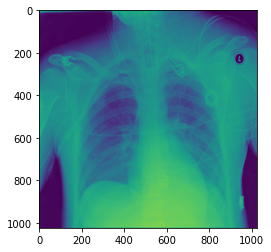

In [50]:
plt.imshow(img_array)

In [61]:
id = path.split('/')[-1][:-4]

In [70]:
for path in  tqdm(data_fpaths):
    Image = sitk.ReadImage(path)
    img_array = sitk.GetArrayFromImage(Image)[0]
    id = path.split('/')[-1][:-4]
    #直接保存测试集
    if 'test' in path:
        save_path = os.path.join(data_root,'test',f'{id}.png')
        cv2.imwrite(save_path,img_array)
    else:
        labels = train_labels[train_labels['patientId'] == id]
        classes = class_info[class_info['patientId'] == id]
        num_label = len(labels.dropna())
        if num_label == 0:
            class_label = classes.iloc[0]['class']
            if class_label == 'Normal':
                save_path = os.path.join(data_root,'negative','normal',f'{id}.png')
                cv2.imwrite(save_path,img_array)
            else:
                save_path = os.path.join(data_root,'negative','notnormal',f'{id}.png')
                cv2.imwrite(save_path,img_array)
        else:
            bboxs = []
            copy_img = img_array.copy()
            for n in range(num_label):
                label = labels.iloc[n]
                x = label['x'] #upper-left
                y = label['y'] #upper-left y
                width = label['width'] 
                height = label['height']
                #bbox coord : (upper-left y,upper-left x,bottom-right y,bottom-right x)
                bbox = [y,x,y+height,x+width]
                bboxs.append(bbox)
#                 cv2.rectangle(copy_img,(int(x),int(y)),(int(x+width),int(y+height)),
#                               [0,255,0],2)
#                 cv2.imshow('DR',copy_img)
#                 cv2.waitKey(0)
            bboxs = np.array(bboxs)
            #验证集稍后分裂
            save_path = os.path.join(data_root,'train',f'{id}.npy')
            np.save(save_path,{'image':img_array,'bboxs':bboxs})

100%|██████████| 135/135 [00:02<00:00, 47.70it/s]


In [78]:
fpaths  = glob.glob(r'./RSNA/train/*.npy')


In [89]:
data = np.load(fpaths[2], allow_pickle=True).item()

image = data['image']
bboxs = data['bboxs']

In [90]:
data

{'bboxs': array([[622., 222., 823., 377.],
        [520., 634., 770., 794.]]), 'image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 3, 3, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 1, 1]], dtype=uint8)}

In [91]:
def visulize(img,bboxs):
    copy_image = img.copy()
    for bbox in  bboxs:
        cv2.rectangle(copy_image,(int(bbox[1]),int(bbox[0])),(int(bbox[3]),int(bbox[2])),[0,255,0],4)
    plt.imshow(copy_image,'gray')

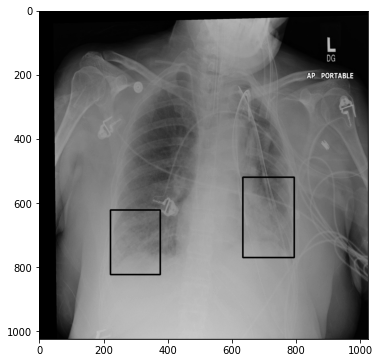

In [92]:
plt.figure(figsize=(20,20))
plt.subplot(131)
visulize(image,bboxs)